In [22]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import display
from pathlib import Path

In [5]:
#@title Set Paths
base_dir = os.getenv('BASE_DIR')
if not base_dir:
    raise ValueError("BASE_DIR environment variable is not set.")

In [ ]:
# Select country
COUNTRY = 'indonesia'

### Store raw files lists
We use this to calculate statistics, e.g get total count of days per site

In [17]:
# Folder containing audio files
audio_dir = Path("/media/mars_5tb_drive/mars_global_acoustic_study/" + COUNTRY + "_acoustics/raw_audio")

# Output CSV path
raw_file_list = os.path.join(base_dir, "marrs_acoustics/data/output_dir_" + COUNTRY + "/raw_file_list.csv")

# Collect all .wav and .WAV files
file_list = [f for f in os.listdir(audio_dir) if f.lower().endswith('.wav')]

# Save the list to a CSV file
file_list_df = pd.DataFrame(file_list, columns=["filename"])
file_list_df.to_csv(raw_file_list, index=False)

print(f"File list saved to {raw_file_list}")


File list saved to /home/bwilliams/ucl_projects/marrs_acoustics/data/output_dir_indonesia/raw_file_list.csv


### Calculate total recording time on each site
Note, each recorder was on a duty cycle of one in two min. So if a recorder has a total of 10 days, that means it collected 10 days of total audio across a 20 day period.

In [24]:
# Extract the 'site name' from the filename (15th and 16th characters)
file_list_df['site_name'] = file_list_df['filename'].str[4:6]

# Count the number of files (minutes of audio) per site
minutes_per_site = file_list_df['site_name'].value_counts().sort_index()

# Convert minutes to days (1440 minutes in a day)
days_per_site = minutes_per_site / 1440

# Convert to DataFrames for full display in Jupyter
minutes_per_site_df = minutes_per_site.reset_index(name="Minutes")
days_per_site_df = days_per_site.reset_index(name="Days")

# Display in list format in Jupyter
print("Minutes of audio per site:")
display(minutes_per_site_df)

print("\nDays of audio per site:")
display(days_per_site_df)


Minutes of audio per site:


,site_name,Minutes
0,D1,15575
1,D2,15138
2,D3,15229
3,D4,15049
4,D5,17578
5,D6,15045
6,H1,15960
7,H2,15628
8,H3,16377
9,H4,3270



Days of audio per site:


,site_name,Days
0,D1,10.815972
1,D2,10.512500
2,D3,10.575694
3,D4,10.450694
4,D5,12.206944
5,D6,10.447917
6,H1,11.083333
7,H2,10.852778
8,H3,11.372917
9,H4,2.270833


### Plot individual sounds
Will plot the mean count per day of 5sec periods that contain the target sound.
As the recorders were on a duty cycle of one in two minutes, we double all counts.

/tmp/ipykernel_222898/2338514167.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['site_name'] = filtered_df['filename'].str[14:16]


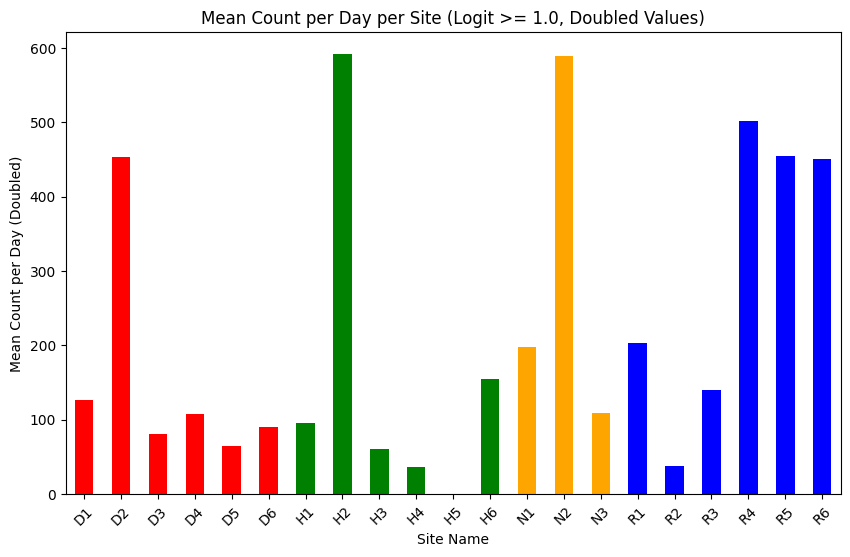

In [26]:
# Set target sound
TARGET_SOUND = 'scrape_fullband'

# Load the CSV file
inference_csv = os.path.join(base_dir, f'marrs_acoustics/data/output_dir_{COUNTRY}/agile_outputs/{TARGET_SOUND}/{TARGET_SOUND}_inference.csv')
inference_df = pd.read_csv(inference_csv)

# Remove leading and trailing spaces from column names
inference_df.columns = inference_df.columns.str.strip()

# Filter rows where 'logit' is 1.0 or higher
filtered_df = inference_df[inference_df['logit'] >= 1.0]

# Extract 'site name' from the 'filename' column (15th and 16th characters)
filtered_df['site_name'] = filtered_df['filename'].str[14:16]

# Count occurrences of each site and sort by site name alphabetically
site_counts = filtered_df['site_name'].value_counts().sort_index()

# Get days of audio per site (from previous code)
days_per_site = minutes_per_site / 1440

# Calculate mean count per day for each site
mean_count_per_day = site_counts / days_per_site

# Double the values for each bar to visualise a higher scale
mean_count_per_day *= 2  # Doubling each value as requested

# Define colours based on the starting letter of each site name
colours = mean_count_per_day.index.map(lambda site: 
    'red' if site.startswith('D') else
    'green' if site.startswith('H') else
    'orange' if site.startswith('N') else
    'blue' if site.startswith('R') else 'grey'  # Default to grey if none of the specified letters match
)

# Plotting
plt.figure(figsize=(10, 6))
mean_count_per_day.plot(kind='bar', color=colours)
plt.title("Mean Count per Day per Site (Logit >= 1.0, Doubled Values)")
plt.xlabel("Site Name")
plt.ylabel("Mean Count per Day (Doubled)")
plt.xticks(rotation=45)
plt.show()
